In [1]:
import subprocess
import shlex
import re
import json

import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import stats

from IPython.display import display, Markdown

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")
TIMING_PATTERN = re.compile(r"\((\d+(?:\.\d+)?)s\)")

In [4]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [5]:
subprocess.run(shlex.split("cargo build --release"), check=True);

CompletedProcess(args=['cargo', 'build', '--release'], returncode=0)

In [6]:
def test_exponential_inter_event_timing(
    mode, delta_t=1.0, lamda=0.5, seeds=[42], limit=10000000000, flags=[],
):
    factor = np.sqrt(10 ** abs(np.log10(lamda * delta_t)))
    
    scaled_limit = int(limit / factor)
    
    timings = []
    
    for seed in seeds:
        output = subprocess.run(shlex.split(
            f"{target_directory}/release/analysis-performance-exponential --delta-t {delta_t} --seed {seed} " +
            f"--lambda {lamda} --limit {scaled_limit} {' '.join(f'--{f}' for f in flags)} {CC_PATTERN.sub('-', mode).lower()}"
        ), check=True, capture_output=True, text=True).stdout
        
        timings.append(float(TIMING_PATTERN.search(output).group(1)) / scaled_limit)
    
    return timings

In [7]:
display(Markdown("# RAM Information:"))

display(Markdown('>```\n' + subprocess.run(
    shlex.split("free"), check=True, capture_output=True, text=True
).stdout.replace('\n', '\n>') + '```'))

display(Markdown("# CPU Information:"))

display(Markdown('>```\n' + subprocess.run(
    shlex.split("lscpu"), check=True, capture_output=True, text=True
).stdout.replace('\n', '\n>') + '```'))

display(Markdown("# GPU Information:"))

display(Markdown('>```\n' + subprocess.run(
    shlex.split("nvidia-smi"), check=True, capture_output=True, text=True
).stdout.replace('\n', '\n>') + '```'))

# RAM Information:

>```
              total        used        free      shared  buff/cache   available
>Mem:       16317628      870052    10433560      253936     5014016    14856604
>Swap:       4194300           0     4194300
>```

# CPU Information:

>```
Architecture:                    x86_64
>CPU op-mode(s):                  32-bit, 64-bit
>Byte Order:                      Little Endian
>Address sizes:                   46 bits physical, 48 bits virtual
>CPU(s):                          8
>On-line CPU(s) list:             0-7
>Thread(s) per core:              2
>Core(s) per socket:              4
>Socket(s):                       1
>NUMA node(s):                    1
>Vendor ID:                       GenuineIntel
>CPU family:                      6
>Model:                           62
>Model name:                      Intel(R) Xeon(R) CPU E5-1620 v2 @ 3.70GHz
>Stepping:                        4
>CPU MHz:                         3521.678
>CPU max MHz:                     3900.0000
>CPU min MHz:                     1200.0000
>BogoMIPS:                        7382.21
>Virtualisation:                  VT-x
>L1d cache:                       128 KiB
>L1i cache:                       128 KiB
>L2 cache:                        1 MiB
>L3 cache:                        10 MiB
>NUMA node0 CPU(s):               0-7
>Vulnerability Itlb multihit:     KVM: Mitigation: VMX disabled
>Vulnerability L1tf:              Mitigation; PTE Inversion; VMX conditional cache flushes, SMT vulnerable
>Vulnerability Mds:               Mitigation; Clear CPU buffers; SMT vulnerable
>Vulnerability Meltdown:          Mitigation; PTI
>Vulnerability Spec store bypass: Mitigation; Speculative Store Bypass disabled via prctl and seccomp
>Vulnerability Spectre v1:        Mitigation; usercopy/swapgs barriers and __user pointer sanitization
>Vulnerability Spectre v2:        Mitigation; Full generic retpoline, IBPB conditional, IBRS_FW, STIBP conditional, RSB filling
>Vulnerability Srbds:             Not affected
>Vulnerability Tsx async abort:   Not affected
>Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm cpuid_fault epb pti ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid fsgsbase smep erms xsaveopt dtherm ida arat pln pts md_clear flush_l1d
>```

# GPU Information:

>```
Wed May 26 16:01:54 2021       
>+-----------------------------------------------------------------------------+
>| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
>|-------------------------------+----------------------+----------------------+
>| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
>| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
>|                               |                      |               MIG M. |
>|===============================+======================+======================|
>|   0  GeForce GTX 1080    Off  | 00000000:05:00.0  On |                  N/A |
>| 28%   34C    P8     7W / 180W |     77MiB /  8119MiB |      0%      Default |
>|                               |                      |                  N/A |
>+-------------------------------+----------------------+----------------------+
>                                                                               
>+-----------------------------------------------------------------------------+
>| Processes:                                                                  |
>|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
>|        ID   ID                                                   Usage      |
>|=============================================================================|
>|    0   N/A  N/A      1874      G   /usr/lib/xorg/Xorg                 74MiB |
>+-----------------------------------------------------------------------------+
>```

In [8]:
lambdas = [
    0.001, 0.002, 0.003, 0.006, 0.01, 0.02, 0.03, 0.06, 0.1, 0.18,
    0.32, 0.56, 1.0, 1.8, 3.2, 5.6, 10.0, 18.0, 32.0, 56.0, 100.0,
    180.0, 320.0, 560.0, 1000.0,
]

seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)

# Different limits to account for GPU timeouts
def limit_for_lambda(lamda):
    if lamda < 1.0:
        return 3162
    
    if lamda <= 100:
        return 10000
    
    return 50000

exp_times = [
    test_exponential_inter_event_timing("Exponential", lamda=lamda, seeds=seeds, limit=limit_for_lambda(lamda), flags=["cuda"])
    for lamda in lambdas
]

# Different limits to account for GPU timeouts
def limit_for_lambda(lamda):
    if lamda <= 100:
        return 7500
    
    return 2500

poi_times = [
    test_exponential_inter_event_timing("Poisson", lamda=lamda, seeds=seeds, limit=limit_for_lambda(lamda), flags=["cuda"])
    for lamda in lambdas
]

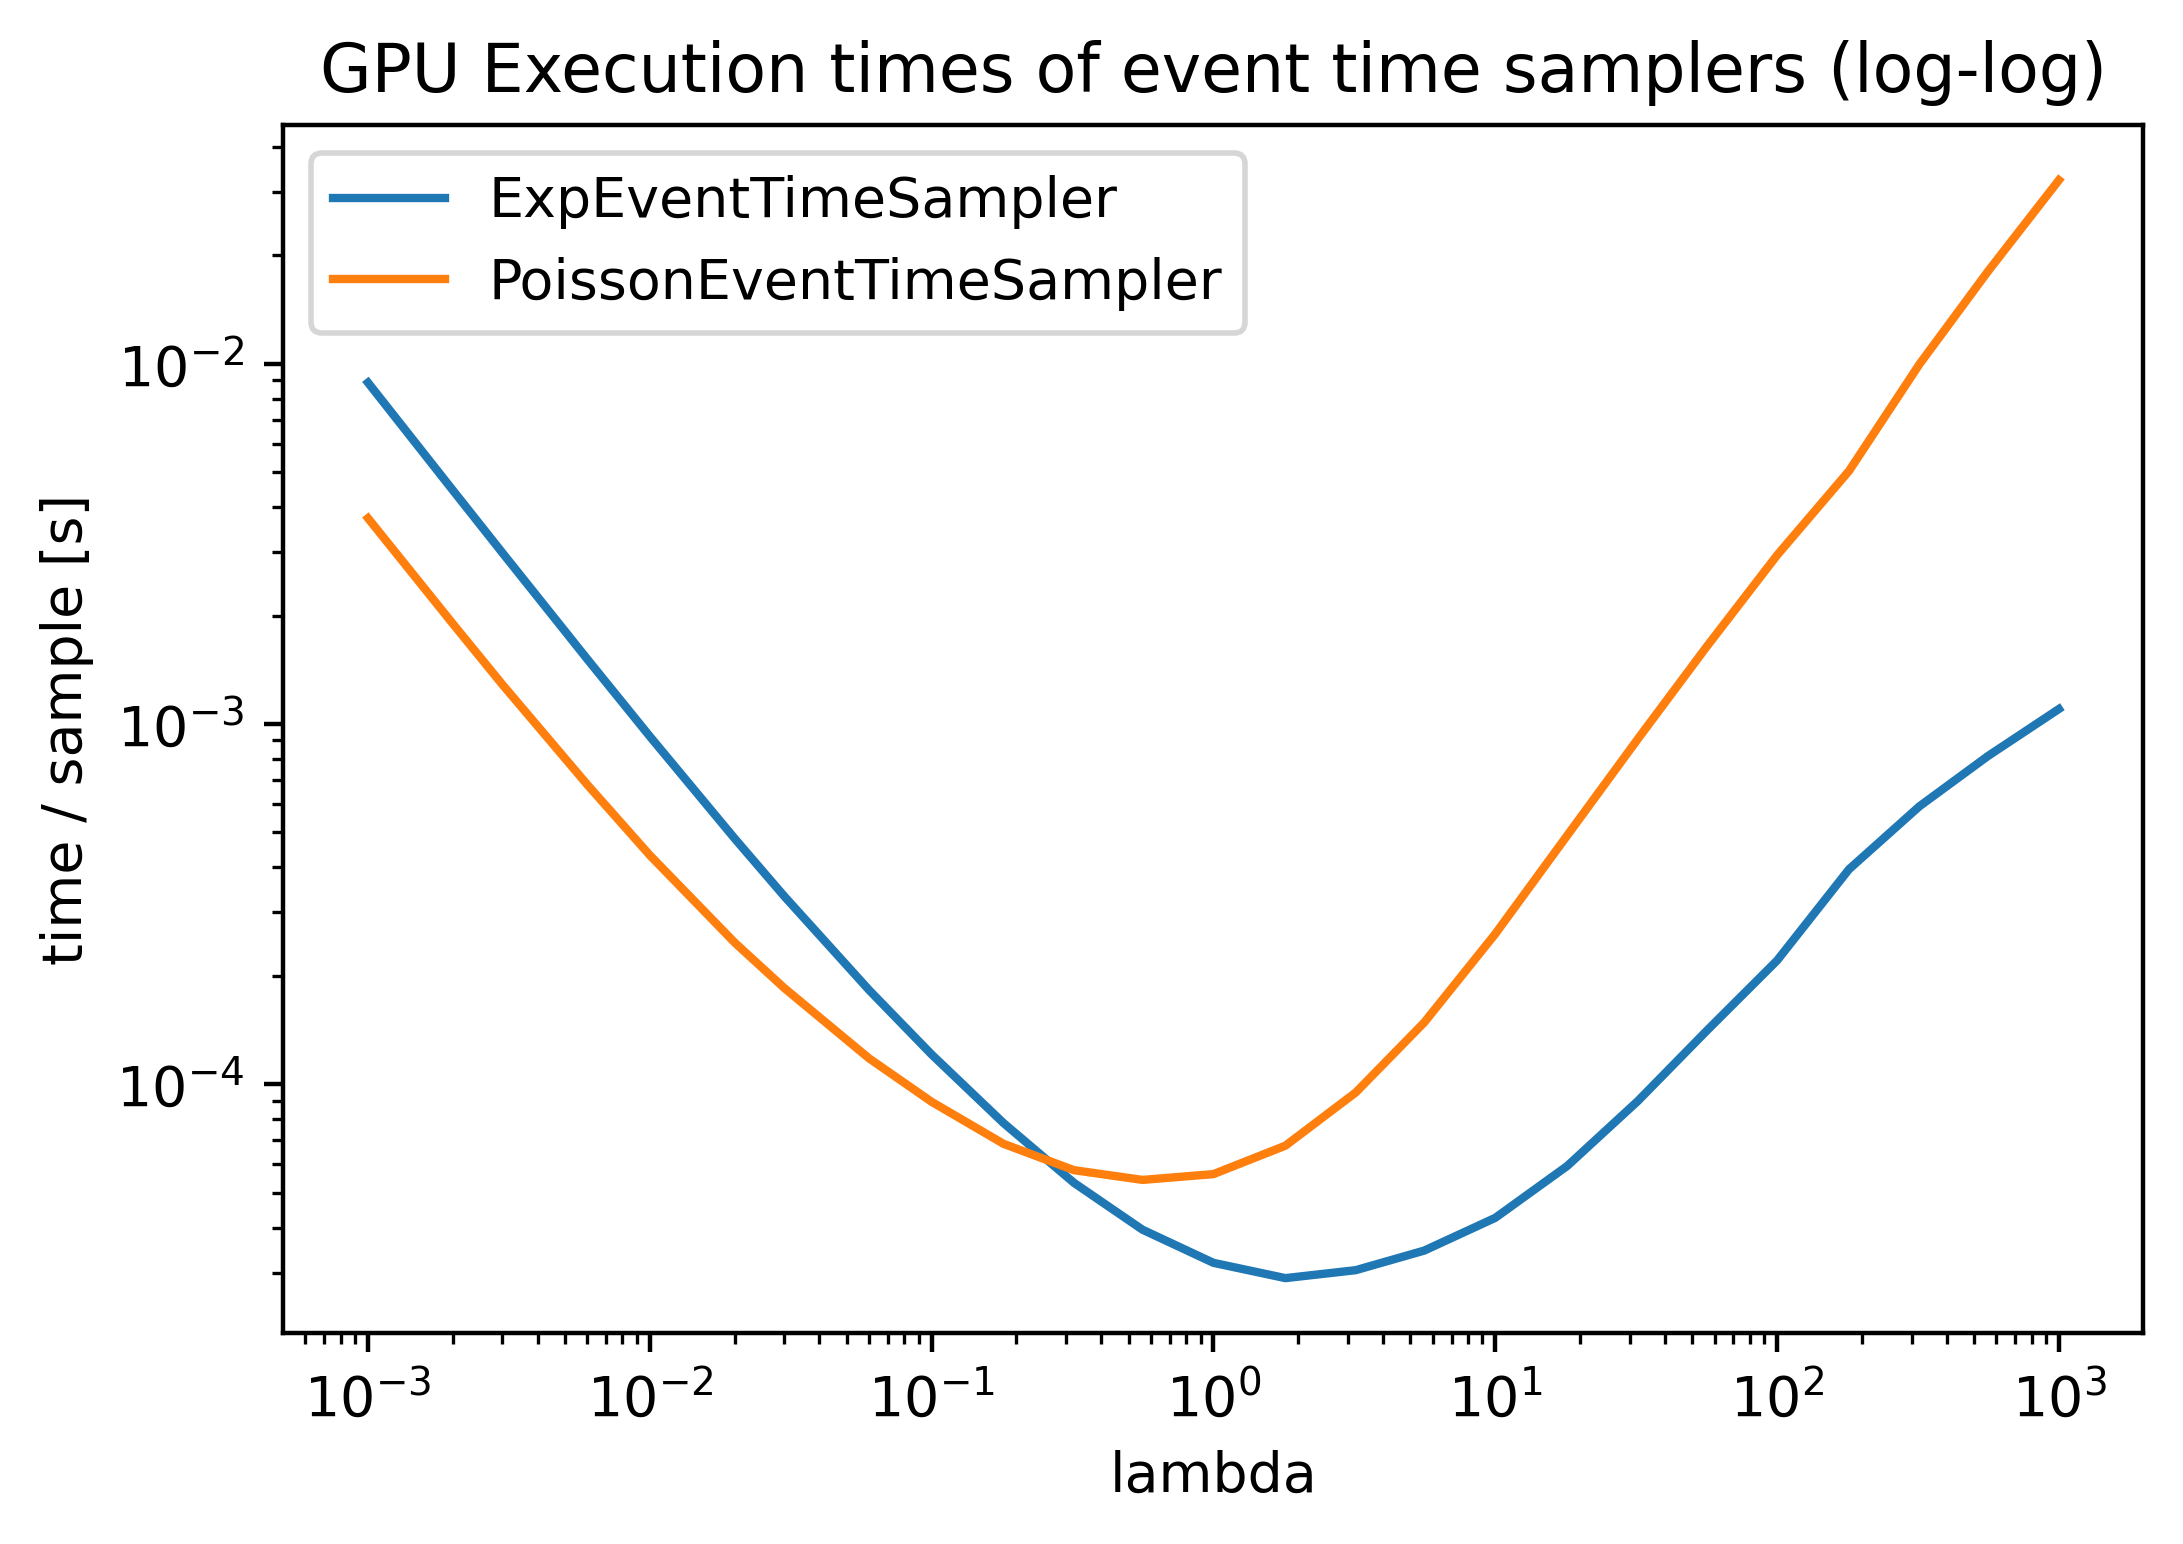

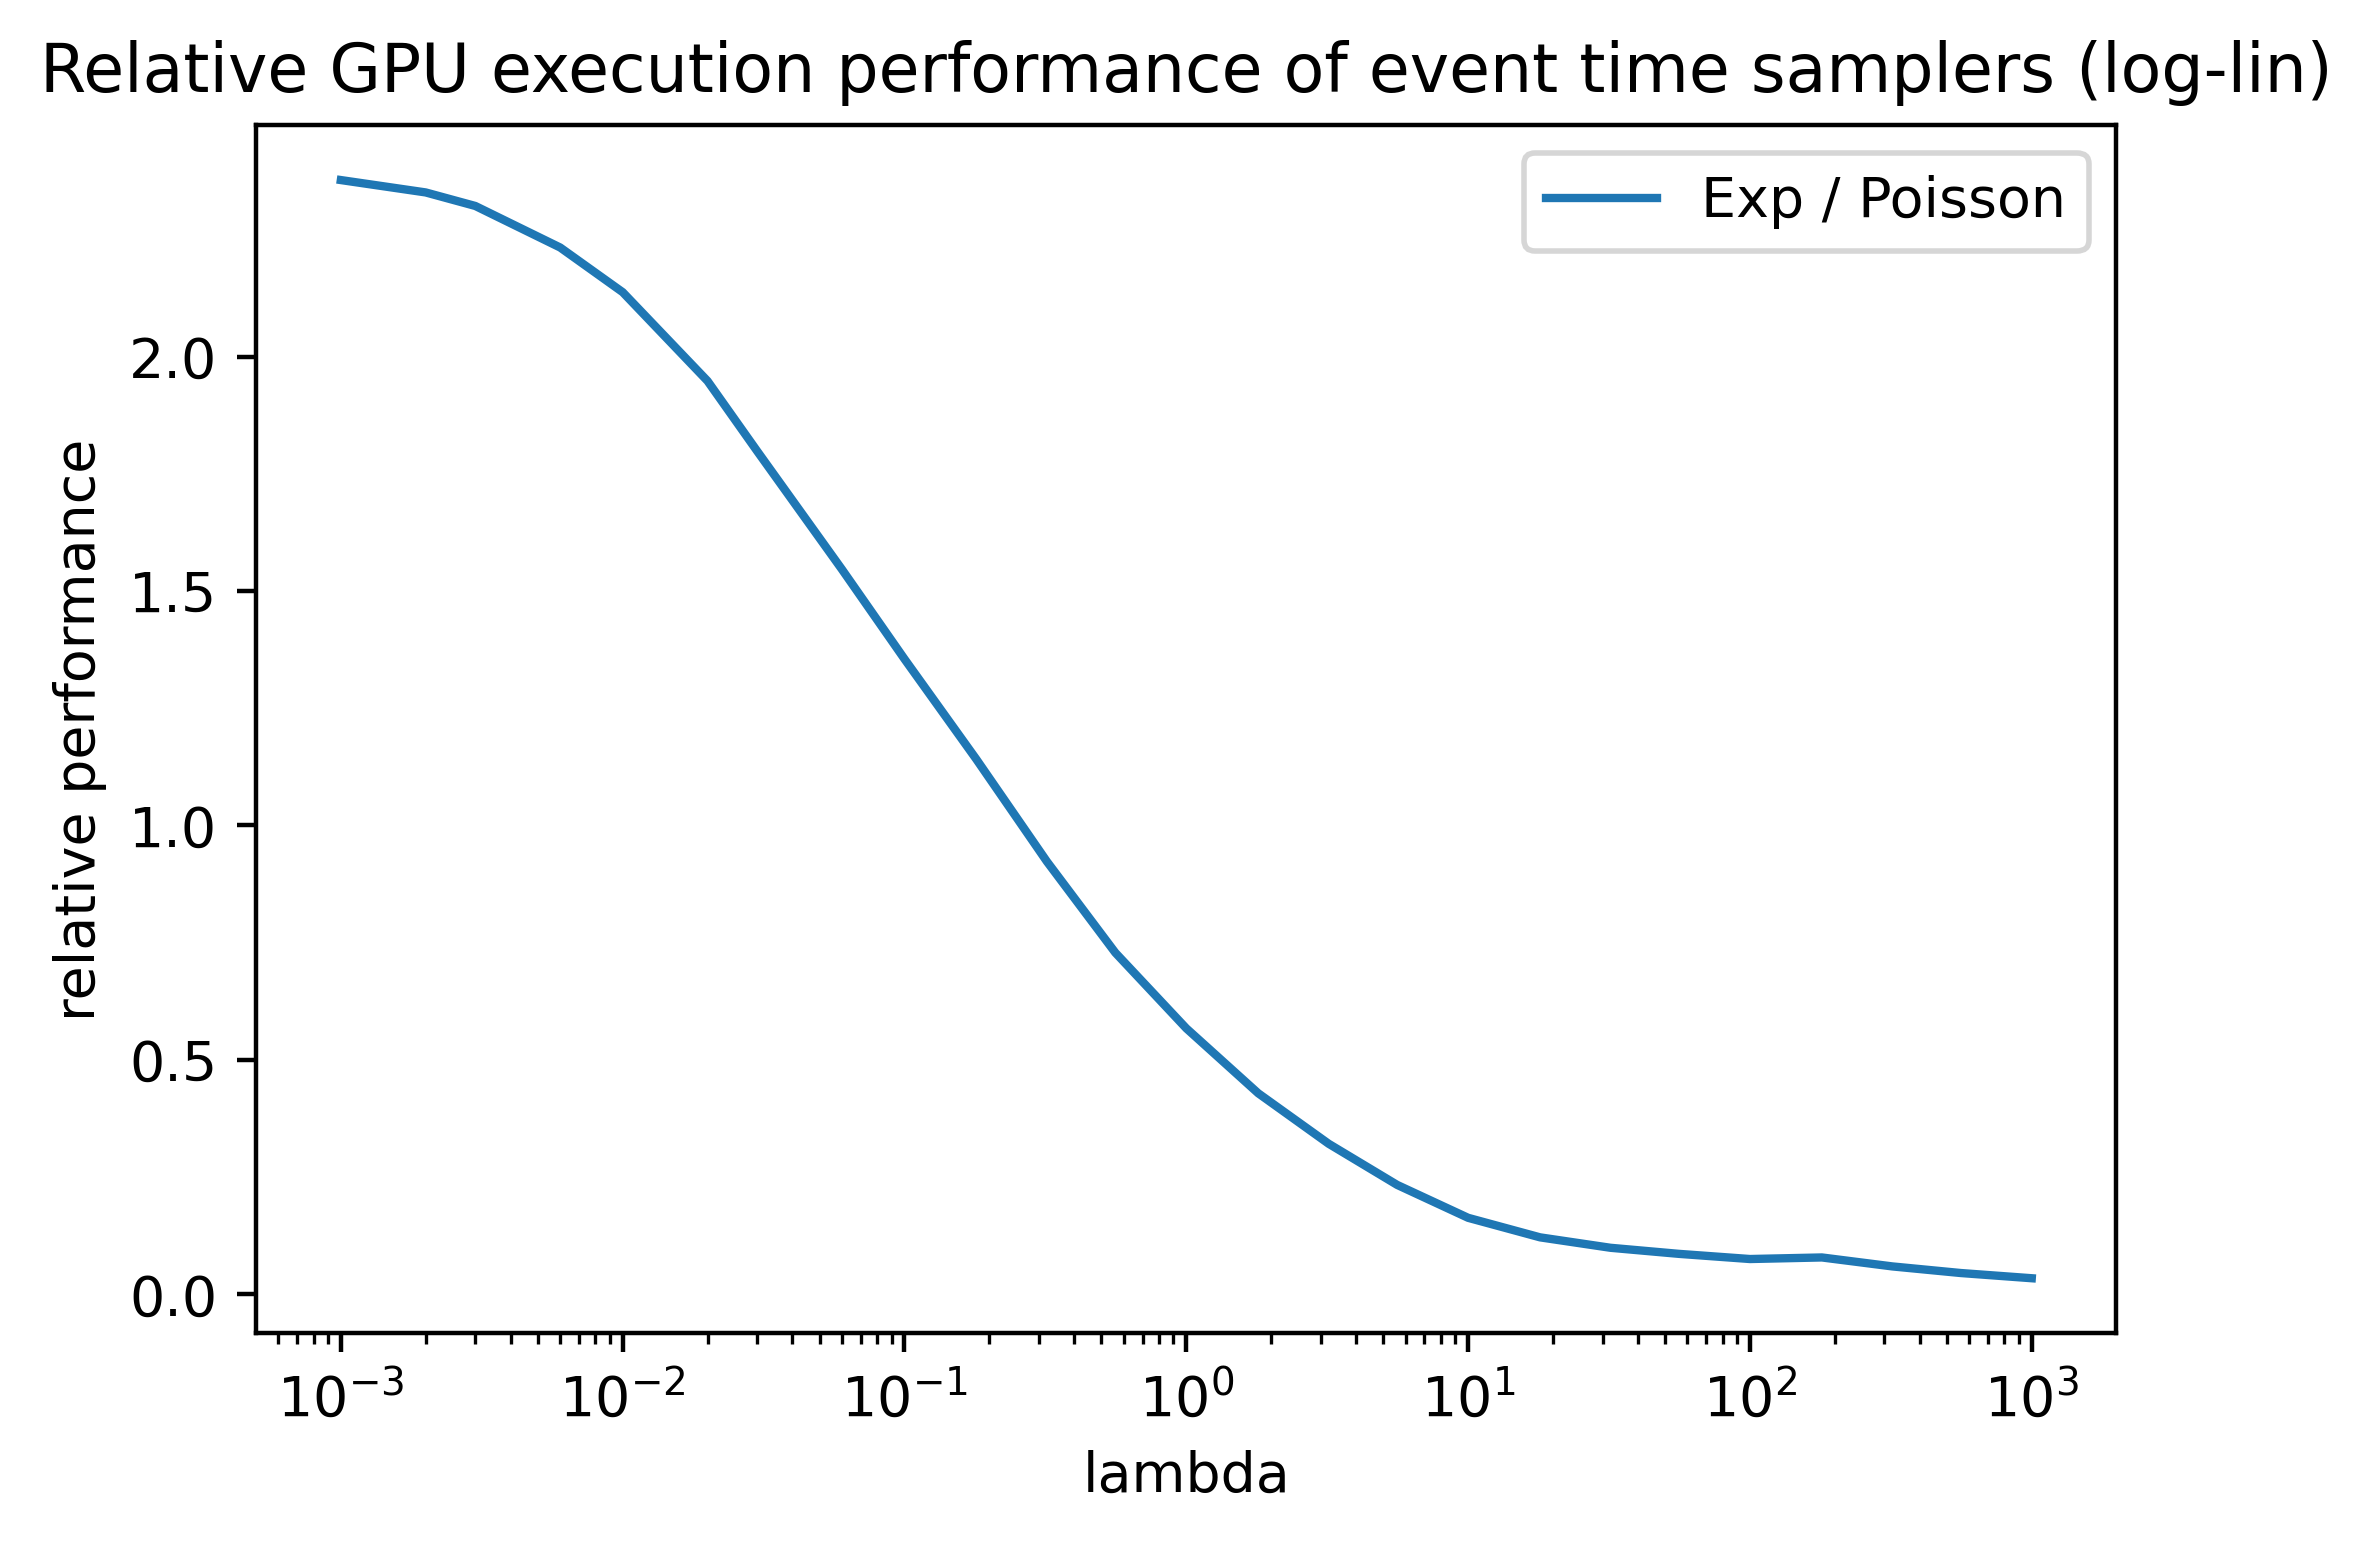

In [9]:
plt.title("GPU Execution times of event time samplers (log-log)")
plt.xlabel("lambda")
plt.ylabel("time / sample [s]")
plt.xscale("log")
plt.yscale("log")

plt.plot(lambdas, np.median(exp_times, axis=1), label="ExpEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(exp_times, axis=1) - np.std(exp_times, axis=1),
    np.mean(exp_times, axis=1) + np.std(exp_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.1
)
plt.plot(lambdas, np.median(poi_times, axis=1), label="PoissonEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(poi_times, axis=1) - np.std(poi_times, axis=1),
    np.mean(poi_times, axis=1) + np.std(poi_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.2
)
plt.legend()
plt.show()

plt.title("Relative GPU execution performance of event time samplers (log-lin)")
plt.xlabel("lambda")
plt.ylabel("relative performance")
plt.xscale("log")
plt.plot(lambdas, [e / p for e, p in zip(np.mean(exp_times, axis=1), np.mean(poi_times, axis=1))], label="Exp / Poisson")
plt.legend()
plt.show()

In [10]:
lambdas = [
    0.001, 0.002, 0.003, 0.006, 0.01, 0.02, 0.03, 0.06, 0.1, 0.18,
    0.32, 0.56, 1.0, 1.8, 3.2, 5.6, 10.0, 18.0, 32.0, 56.0, 100.0,
    180.0, 320.0, 560.0, 1000.0, 1800, 3200, 5600, 10000,
]

seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)

exp_times = [
    test_exponential_inter_event_timing("Exponential", lamda=lamda, seeds=seeds, limit=1000000)
    for lamda in lambdas
]
poi_times = [
    test_exponential_inter_event_timing("Poisson", lamda=lamda, seeds=seeds, limit=1000000)
    for lamda in lambdas
]

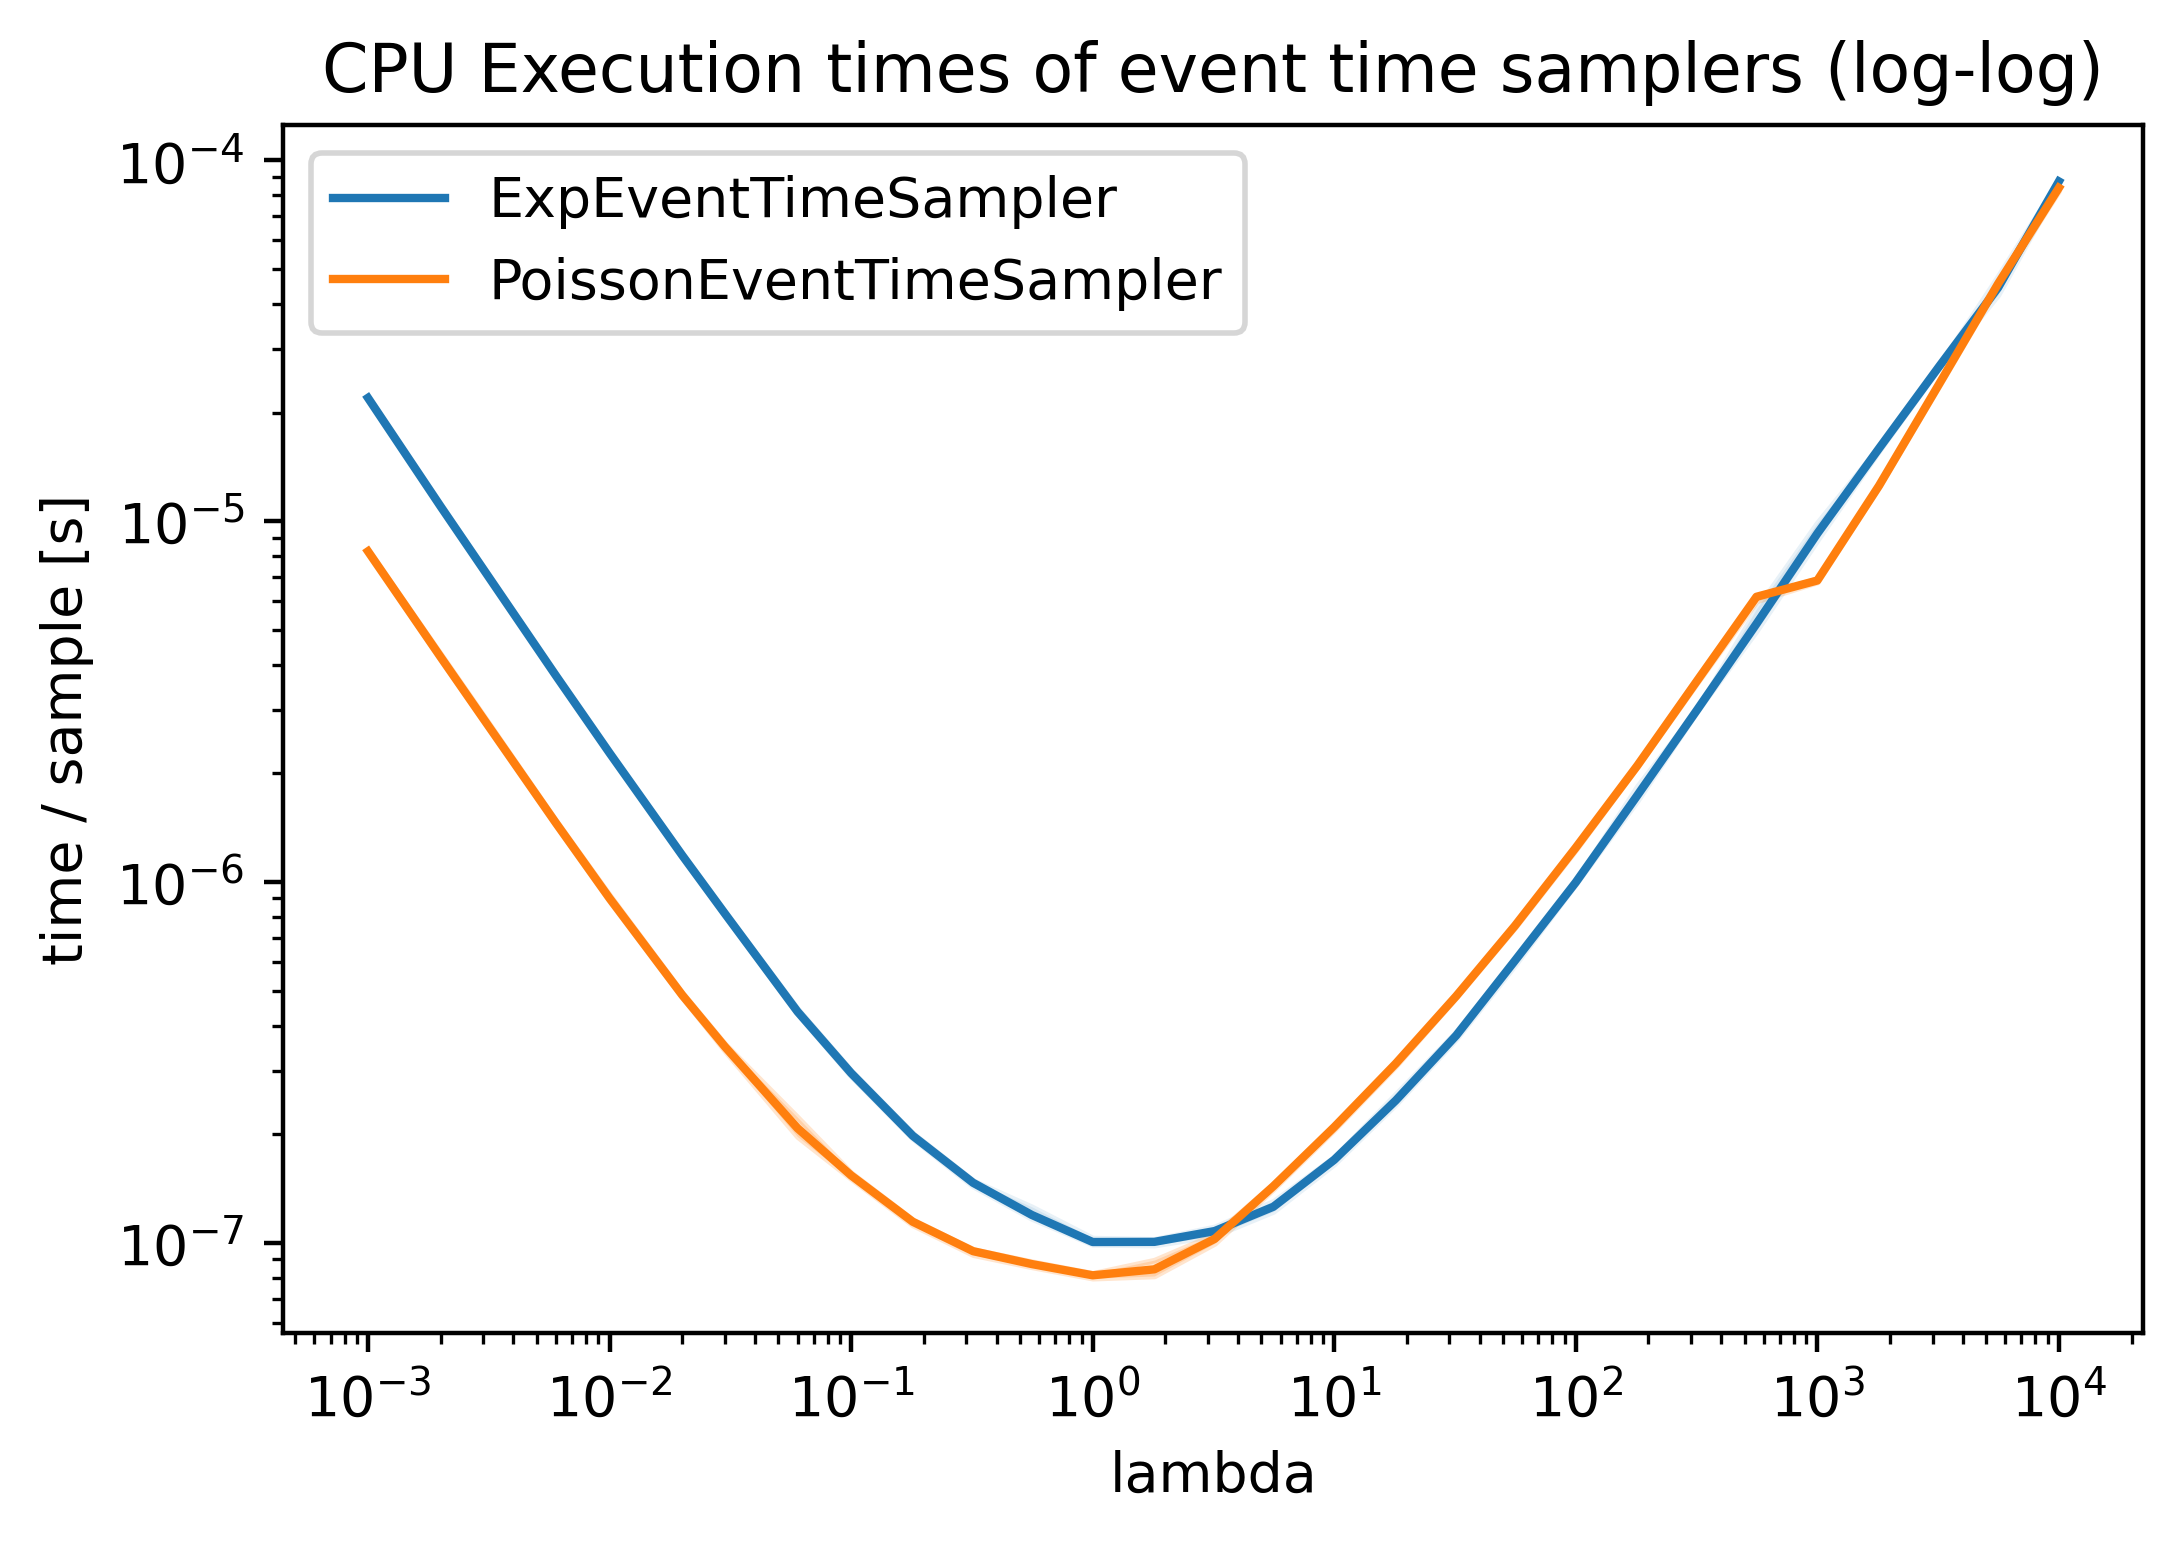

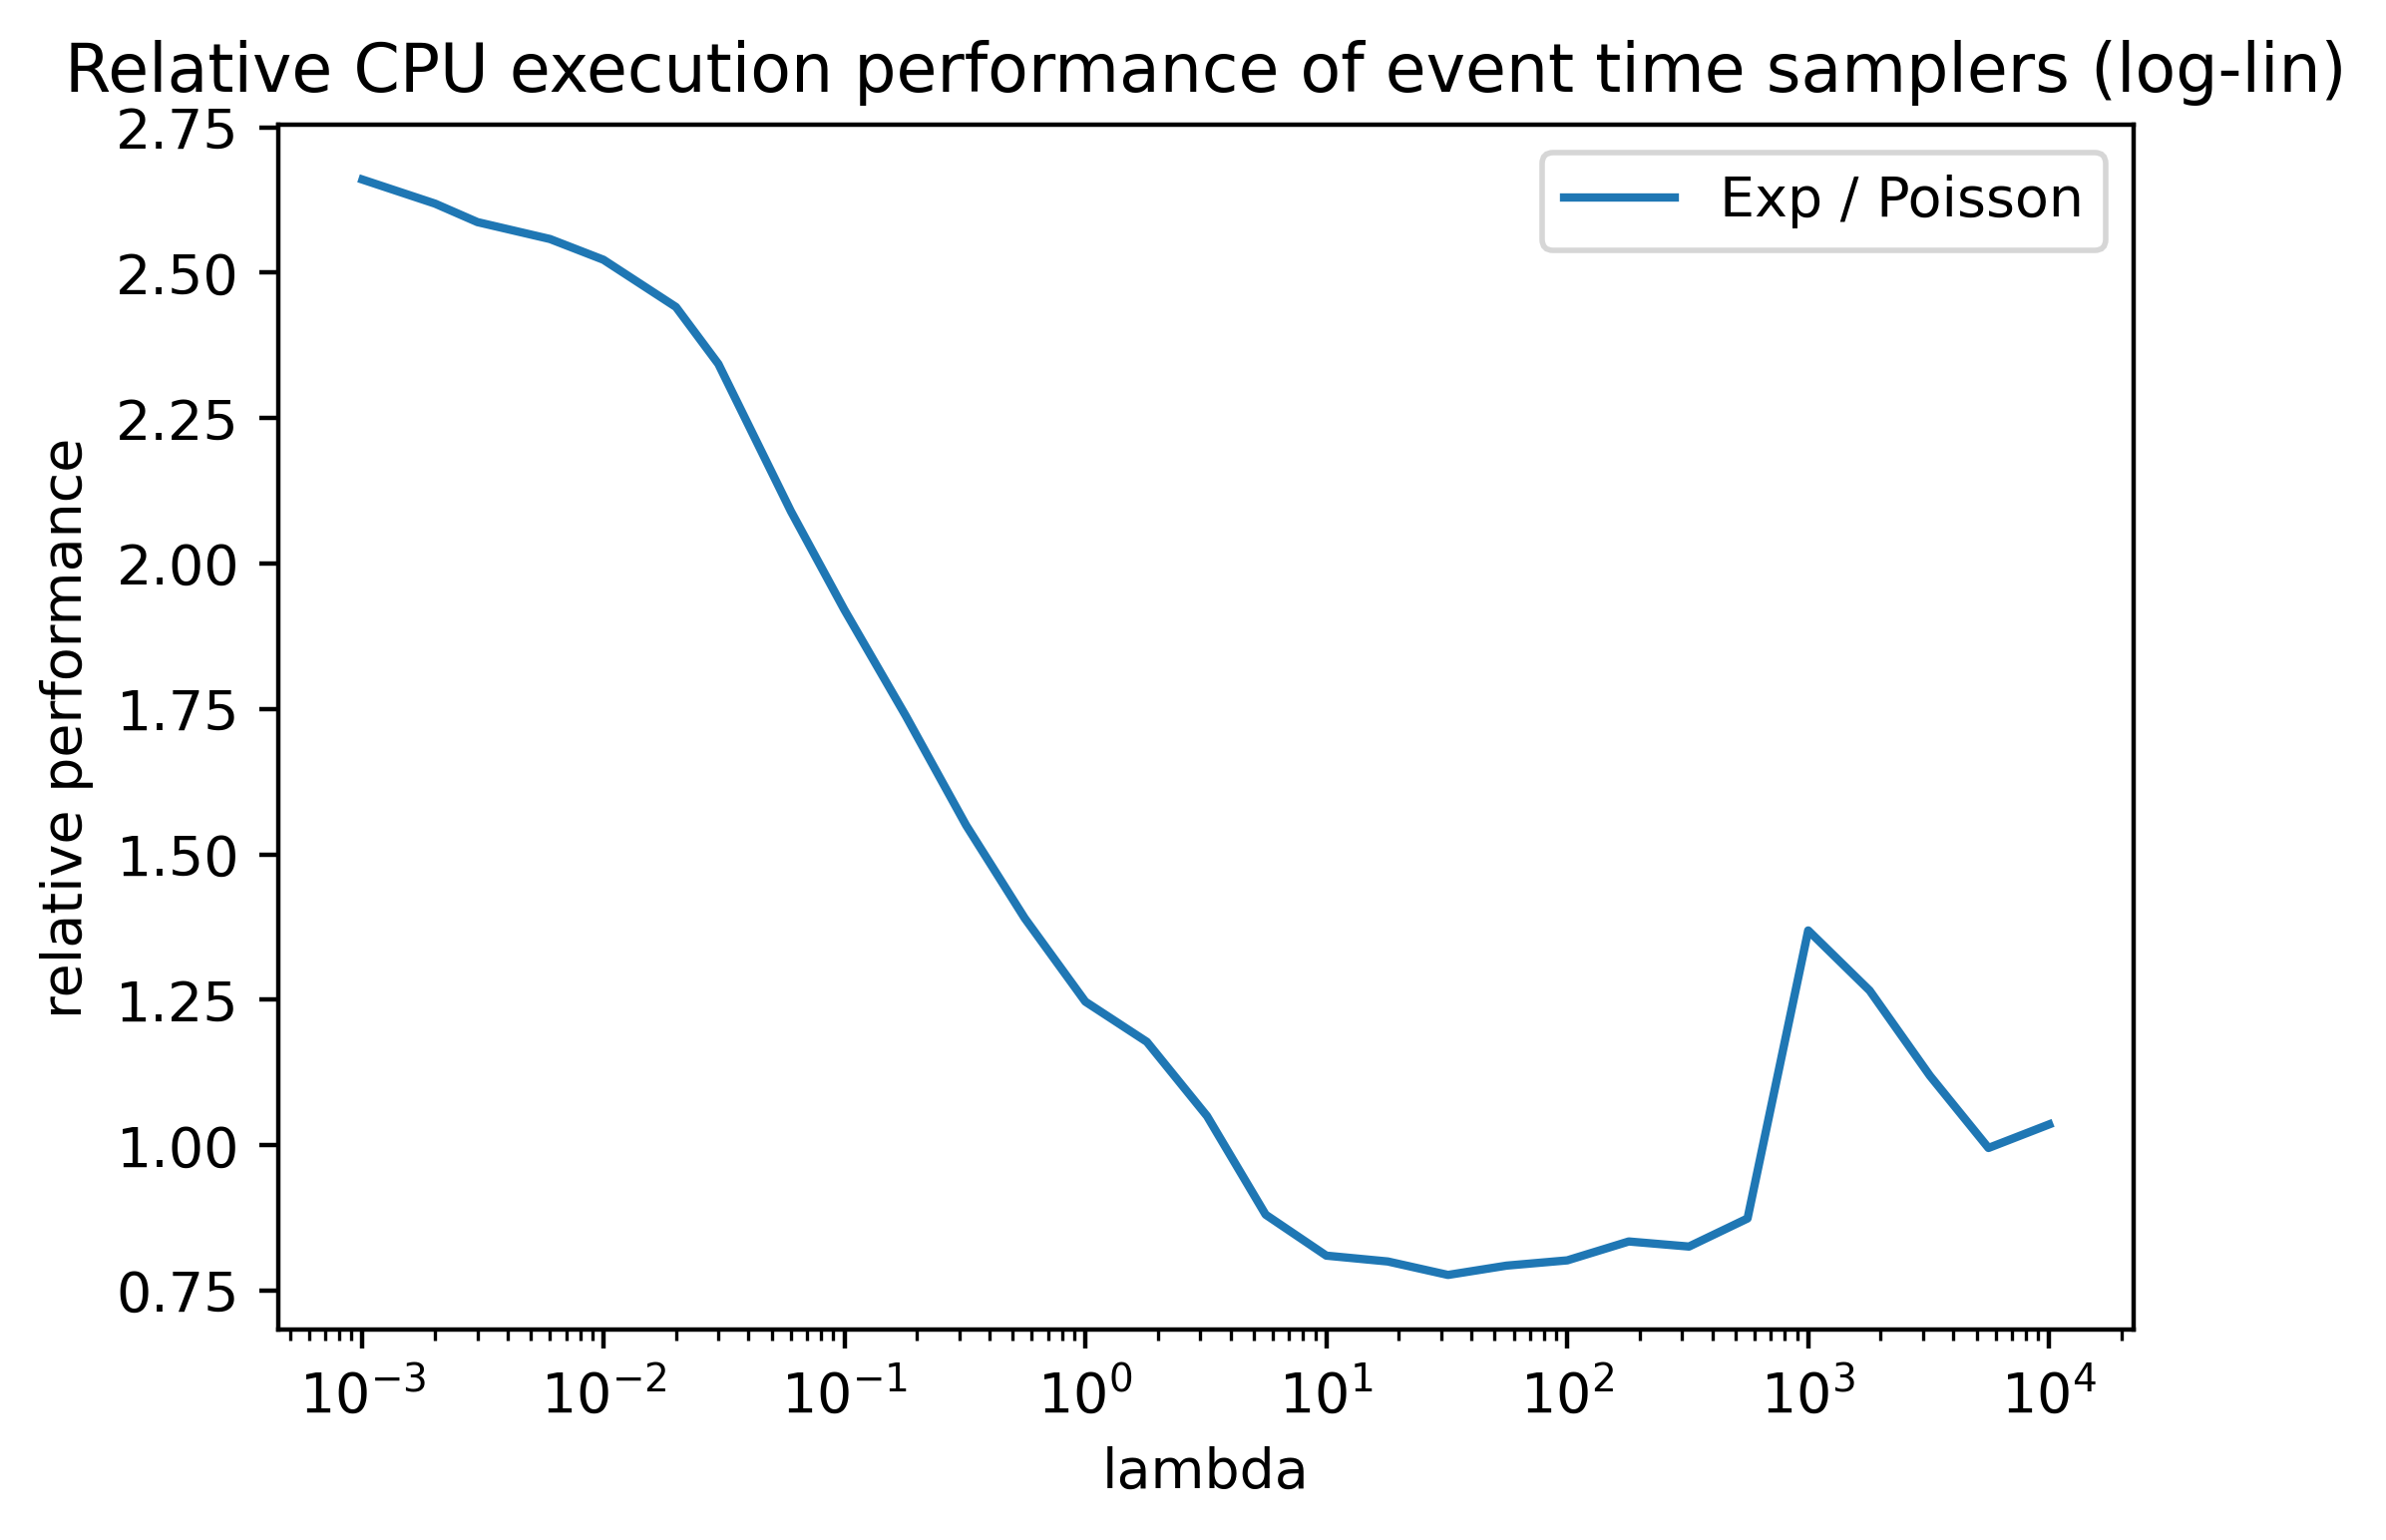

In [11]:
plt.title("CPU Execution times of event time samplers (log-log)")
plt.xlabel("lambda")
plt.ylabel("time / sample [s]")
plt.xscale("log")
plt.yscale("log")

plt.plot(lambdas, np.median(exp_times, axis=1), label="ExpEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(exp_times, axis=1) - np.std(exp_times, axis=1),
    np.mean(exp_times, axis=1) + np.std(exp_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.1
)
plt.plot(lambdas, np.median(poi_times, axis=1), label="PoissonEventTimeSampler")
plt.fill_between(
    lambdas,
    np.mean(poi_times, axis=1) - np.std(poi_times, axis=1),
    np.mean(poi_times, axis=1) + np.std(poi_times, axis=1),
    color=plt.gca().lines[-1].get_color(), alpha=0.2
)
plt.legend()
plt.show()

plt.title("Relative CPU execution performance of event time samplers (log-lin)")
plt.xlabel("lambda")
plt.ylabel("relative performance")
plt.xscale("log")
plt.plot(lambdas, [e / p for e, p in zip(np.mean(exp_times, axis=1), np.mean(poi_times, axis=1))], label="Exp / Poisson")
plt.legend()
plt.show()